In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer
# import holoviews as hv
# from holoviews import opts

# hv.extension('bokeh', 'matplotlib')

In [2]:
%run -i ncbx_funcs.py

In [3]:
url_CSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/dorian_his.ncml'
url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
url_FSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/dorian_his.ncml'
url_FSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/dorian_his.ncml'
#url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
ds_CSYV = xr.open_dataset(url_CSYV)
ds_CSYV

<xarray.Dataset>
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 37,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9375 -0.8125 ... -0.1875 -0.0625
  * s_w                     (s_w) float64 -1.0 -0.875 -0.75 ... -0.25 -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 ...
    lat_rho                 (eta_rho, xi_rho) float64 ...
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T10:15:00.0...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00019.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  varinfo.dat
    ...                        ...
    tiling:                    015x012
    history:                   ROMS/TOMS, Version 3.9, Saturday - October 15,...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         8
    EXTRA_DIMENSION.boundary:  4

In [27]:
# load lat/lon, convert to island coordinates
lon = np.squeeze( ds_CSYV.lon_rho.load().values )
lat = np.squeeze( ds_CSYV.lat_rho.load().values )

# Convert lat/lon to UTM zone 18N, and then to island coordinates
transformer = Transformer.from_crs( 'epsg:4326', 'epsg:26918',  ) # WGS84 to UTM18
utmx, utmy = transformer.transform( lat, lon )
xisl, yisl = UTM2Island(utmx, utmy, eoff=383520.0, noff=3860830.0, rot=42.0)
print('Shape of xisl, yisl: ', xisl.shape, yisl.shape)


Shape of xisl, yisl:  (1057, 1317) (1057, 1317)


In [9]:
# load initial and final bathymetry
# Minus sign converts from depth to elevation
bathi = -ds_CSYV.bath[1,:,:].load().values
bathf = -ds_CSYV.bath[-1,:,:].load().values
bdiff = bathf - bathi

pm = ds_CSYV.pm[:,:].load().values
pn = ds_CSYV.pn[:,:].load().values
area = 1./pm * 1./pn
print('Shape of area: ', area.shape)

vdiff = bdiff * area
print(np.sum(area))
print(np.sum(bdiff))
print(np.sum(vdiff))
print('bdiff')
stat_summary(bdiff, iprint=True)
print('vdiff')
stat_summary(vdiff, iprint=True)

Shape of area:  (1057, 1317)
19821987.311535504
-70593.43
243145.0925447774
bdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : -0.051 0.353 -4.542 1.478
  d5, d25, d50, d75, d95: -0.410 -0.023 0.001 0.018 0.196
vdiff
  n, nnan, nvalid:  1057 0 1057
  mean, std, min, max   : 0.175 1.929 -49.830 70.158
  d5, d25, d50, d75, d95: -1.315 -0.134 0.005 0.146 2.611


{'n': 1057,
 'nnan': 0,
 'nvalid': 1057,
 'mean': 0.1746645407266288,
 'std': 1.9289193419431026,
 'min': -49.83044298234731,
 'max': 70.15775635512807,
 'd5': -1.315193128668792,
 'd25': -0.1340415790105609,
 'd50': 0.0045960437262363195,
 'd75': 0.146177606007145,
 'd95': 2.6111112905774303}

In [28]:
# Use a central line for cross-shore distance
y = np.squeeze( yisl[:,550] )

# find the average shoreline location
mbathi = np.mean(bathi[:,100:1200], axis=1)
mbathf = np.mean(bathi[:,100:1200], axis=1)
ishorey = np.argwhere(mbathi>=0.)[0]
print(ishorey, y[ishorey])

# use this for the cross-shore location by adding the offset
y = y-y[ishorey]
yisl = yisl-y[ishorey]
xisl = xisl-np.min(xisl)

[168] [329.27781985]


In [48]:
sed2i = np.squeeze( ds_CSYV.sandmass_02[0,:,:,:].load().values )
sed2f = np.squeeze( ds_CSYV.sandmass_02[-1,:,:,:].load().values )
sed3i = np.squeeze( ds_CSYV.sandmass_03[0,:,:,:].load().values )
sed3f = np.squeeze( ds_CSYV.sandmass_03[-1,:,:,:].load().values )
np.shape(sed2i)

(1057, 1317)

/tmp/ipykernel_365853/1113363073.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m0=ax0.pcolormesh(xisl, yisl-329, (sed2f-sed2i)+(sed3f-sed3i), cmap='seismic',vmin=-5000, vmax=5000)


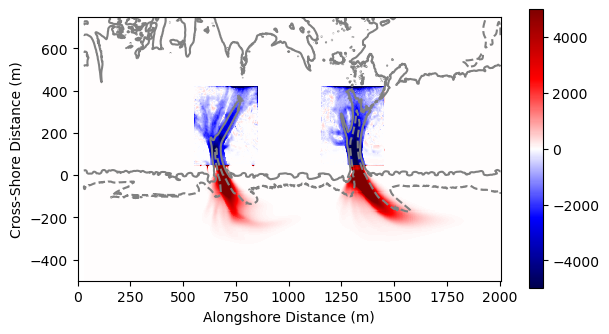

In [53]:
xs = 0
xe = 15800
ys = -500
ye = 750
levels = np.array( [-1., 0.] )

fig, (ax0) = plt.subplots(1,1,figsize=(6,8),sharex=True)
m0=ax0.pcolormesh(xisl, yisl-329, (sed2f-sed2i)+(sed3f-sed3i), cmap='seismic',vmin=-5000, vmax=5000)
ax0.contour(xisl, yisl-329, bathf, levels, colors='gray')
#ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.set_aspect('equal')
ax0.set_ylabel('Cross-Shore Distance (m)')
ax0.set_xlabel('Alongshore Distance (m)')
plt.colorbar(m0,fraction=0.03, pad=0.06)


(1057,)
-734033.5671668672


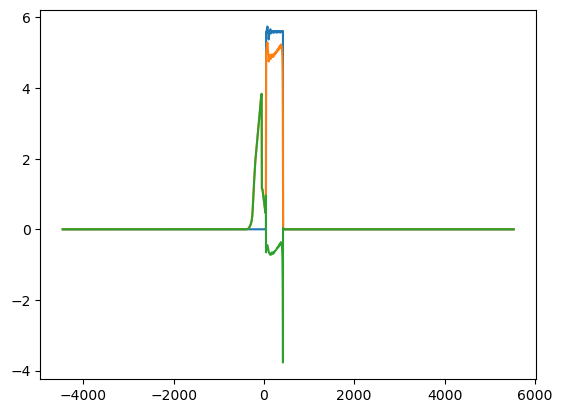

In [63]:
dy = np.diff(y)
dy = np.append( dy, dy[-1] )

voli = dy*np.sum( (sed2i + sed3i), axis=1 )
volf = dy*np.sum( (sed2f + sed3f), axis=1 )

delvol = volf-voli
print(np.shape(delvol))
plt.plot(y, voli/1.e6 )
plt.plot(y, volf/1.e6 )
plt.plot(y, delvol/1.e6 )

ValueError: x and y must have same first dimension, but have shapes (1057,) and (1392069,)

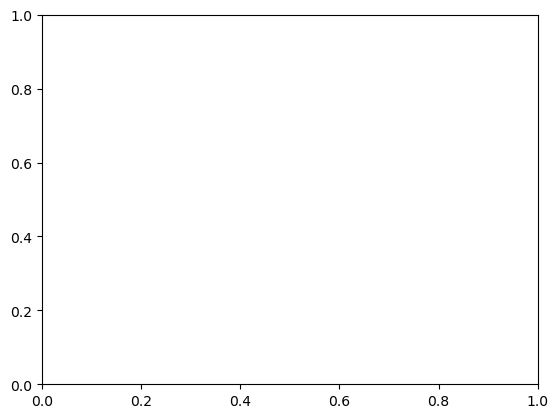

In [59]:
plt.plot(y, np.cumsum( (sed2i+sed3i)/1.e6 ) )

In [ ]:
# these start/stop values are before shifting to mean shoreline position
xs = 14200
xe = 15800
ys = -1750
ye = 750
zlevels = [-4, -2, 0, 2, 4]
fig, (ax0) = plt.subplots(1,1,figsize=(6,8),sharex=True)
m0=ax0.pcolormesh(xisl, yisl-329., bdiff, cmap='seismic', vmin=-4, vmax=4)
# ax0.contour(xisl, yisl-329., bdiff, zlevels, colors='gray')
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.set_aspect('equal')
ax0.set_ylabel('Cross-Shore Distance (m)')
ax0.set_xlabel('Alongshore Distance (m)')
plt.colorbar(m0,fraction=0.036, pad=0.06)

In [44]:
print(np.shape(bdprof))

(1057,)


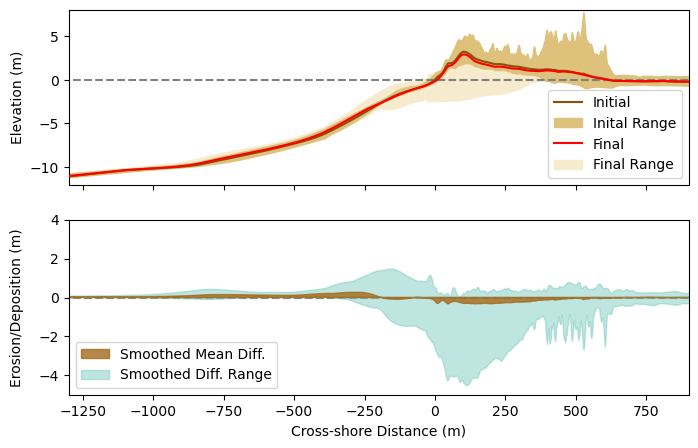

In [31]:
cmap = plt.get_cmap('BrBG')

ys = -1300
ye = 900

bdprof = running_mean( np.mean(bdiff[:,100:1200], axis=1), 5 )
bdprofmin = running_mean( np.min(bdiff[:,100:1200], axis=1), 5 )
bdprofmax = running_mean( np.max(bdiff[:,100:1200], axis=1), 5 )

bathyi_max = running_mean( np.max(bathi[:,100:1200], axis=1), 5 )
bathyi_min = running_mean( np.min(bathi[:,100:1200], axis=1), 5 )
bathyf_max = running_mean( np.max(bathf[:,100:1200], axis=1), 5 )
bathyf_min = running_mean( np.min(bathf[:,100:1200], axis=1), 5 )

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8,5),sharex=True)
ax0.plot(y, np.zeros_like(y),'--',c='gray')
ax0.plot(y, np.mean(bathi[:,100:1200], axis=1), c = cmap(.1),label='Initial', zorder=3)
ax0.fill_between(y, bathyi_max, bathyi_min, color = cmap(.3), label='Inital Range', zorder=1)
ax0.plot(y, np.mean(bathf[:,100:1200], axis=1), '-r',label='Final', zorder=3 )
ax0.fill_between(y, bathyf_max, bathyf_min, color = cmap(.42), label='Final Range', zorder=0)
# ax0.plot(y, bathy_max, '-k',label='Max')
# ax0.plot(y, bathy_min, '-k',label='Min')
ax0.legend()
ax0.set_ylabel('Elevation (m)')


ax0.set_xlim([ys, ye])
ax0.set_ylim([-12, 8])

ax1.plot(y,np.zeros_like(y),'--',c='gray',zorder=0)
ax1.fill_between(y,bdprof,0,label='Smoothed Mean Diff.',color=cmap(.15),alpha=.8,zorder=1)
ax1.fill_between(y,bdprofmin,0,label='Smoothed Diff. Range',color=cmap(.7),alpha=.5, zorder=0)
ax1.fill_between(y,bdprofmax,0, color=cmap(.7),alpha=.5, zorder=0)
ax1.set_xlim([ys, ye])
ax1.set_ylim([-5, 4])
ax1.set_xlabel('Cross-shore Distance (m)')
plt.legend(loc='lower left')
ax1.set_ylabel('Erosion/Deposition (m)')
#fig.text(0.04, 0.5, 'Elevation (m)', va='center', rotation='vertical')
fig.align_labels()
figname = 'erosion_deposition_cross_section.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')

In [ ]:
dy = np.diff(y)
dy = np.append( dy, dy[-1] )
cumdep = np.cumsum( bdprof*dy )
cumdepf = np.cumsum( np.flip(bdprof*dy) )

imax = np.argmax( cumdep )
cummax = cumdep[imax]
print(cummax)
print('net positive at :',y[imax] )

i50 = np.argwhere( cumdep/cummax >= 0.5 )[0]
print( 'y50, z50: ',y[i50], mbathi[i50] )
i25 = np.argwhere( cumdep/cummax >= 0.25 )[0]
print( 'y25, z25: ',y[i25], mbathi[i25] )
i5 = np.argwhere( cumdep/cummax >= 0.05 )[0]
print( 'y5, z5: ',y[i5], mbathi[i5] )

plt.plot(y, cumdep/cummax, linewidth=2, c='red', label='Fractional Cum. Depostion ( )')
plt.fill_between(y, bdprof, 0, color=cmap(.15),alpha=.8,zorder=1, label='Smoothed Mean Diff (m)')
plt.legend( loc = 'upper left')
plt.ylim( -.4, 1.1 )
plt.xlim( -1500, 0 )
plt.xlabel('Cross-shore Distance (m)')
plt.ylabel('Meters')
figname = 'cumulative_cross_section.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')

In [ ]:
plt.plot(np.flip(y), cumdepf, linewidth=2, c='red', label='Fractional Cum. Depostion ( )')


In [ ]:
nx, ny = np.shape(bathi)
print(nx, ny)
ip = np.arange(0,ny)
icrest = np.ones_like(ip)

In [ ]:
# dune crests
for i in ip:
    icrest[i]=np.argmax(-bathi[0:350,i])
    
from scipy.signal import medfilt
icf = medfilt(icrest, 17)

zi = np.ones_like(ip).astype(float)
zif = np.ones_like(ip).astype(float)
for i in ip:
    zi[i] = -bathi[icrest[i],i]
    zif[i]= -bathi[icf[i],i]
    


In [ ]:
plt.pcolormesh(-bathi[0:350,:])
plt.plot(ip,icrest,'.r')
plt.plot(ip,icf,'ow')

In [ ]:
plt.plot(zi)
plt.plot(zif)

In [ ]:
plt.plot(-bathf[50:350,600],label='Final')
plt.plot(-bathi[50:350,600],label='Initial')
plt.legend()
print(np.argmax(-bathi[0:350,600]))

In [ ]:
plt.plot(-bathf[50:350,418:425],label='Final')
plt.plot(-bathi[50:350,418:425],label='Initial')
plt.legend()

In [ ]:
plt.plot(-bathf[245,:],label='Final')
plt.plot(-bathi[245,:],label='Initial')
plt.legend()